# Optimization

In [1]:
import modules
import optimization
import numpy as np
import importlib
importlib.reload(modules)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

max_iter = 2000

# print objective function, WEC rated power, carrying capacity, constraints, design variables
def print_bold(str):
    print('\033[1m' + str + '\033[0;0m')
    return

def print_objective(title, x0, x_name, p):
    print_bold(title+" objective function terms:")
    cost_per_yield, price, fish_yield, _, _ = modules.obj_terms(x0, x_name, p)
    print(' '*2, "cost_per_yield", "{:10.3f}".format(cost_per_yield), '[$/kg]')
    print(' '*2, "price         ", "{:10.3f}".format(price), '[$]')
    print(' '*2, "fish_yield    ", "{:10.3f}".format(fish_yield), '[kg]')
    print("-"*40)

def print_P_rated(title, x0, x_name, p):
    print_bold(title+" WEC rated power:")
    P_rated = modules.P_rated(x0, x_name, p)
    print(' '*2, "P_rated     ", "{:10.3f}".format(P_rated/1000), '[kW]')
    print("-"*40)

def print_carrying_capacity(title, x0, x_name, p):
    print_bold(title+" carrying capacity:")
    TPF_O2, CC = modules.carrying_capacity_print(x0, x_name, p)
    print(' '*2, "TPF_O2              ", "{:10.3f}".format(TPF_O2), '[kg fish/year]')
    print(' '*2, "Carrying Capacity   ", "{:10.3f}".format(CC), '[kg fish]')
    print("-"*40)
    
def print_ineq_cons(title,x0, x_name, p):
    print_bold(title+" constraints:")
    print(' '*2, "normalized P_gen_cons          ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[0]), '[-]')
    print(' '*2, "normalized fish_yield_cons     ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[1]), '[-]')
    print(' '*2, "normalized pen_ratio_low_cons  ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[2]), '[-]')
    print(' '*2, "normalized pen_ratio_up_cons   ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[3]), '[-]')
    print("-"*40)
            
def optimize_result(x_name, x_list, x_unit, res, p, opt_idx):
    col_width = len(max(x_list, key=len))
    print(res[opt_idx].success)
    print_bold("optimal design variable:")
    for i in range(len(x_list)):
        print(' '*2, x_list[i], ' '*(col_width - len(x_list[i])) , "{:10.3f}".format(res[opt_idx].x[i]), x_unit[i])
    print("-"*40)

    print_P_rated("optimal",res[opt_idx].x, x_name, p)
    print_objective("optimal",res[opt_idx].x, x_name, p)
    print_ineq_cons("optimal",res[opt_idx].x, x_name, p)
    print_carrying_capacity("optimal",res[opt_idx].x, x_name, p)
    
    
# list all system desgin variables and parameters
all_vars = ['x_wec','x_type_wec','x_pen','p_pen','x_env','p_env','p_wec','p_fish_salmon']

wec_types = ['point absorber'] #{'attenuator','terminator','point absorber']

# list design variables
x_name = ['x_wec','x_pen']
x_list, x0_val, x_unit, x_bnds, x_label = optimization.default_value(x_name)
x0 = []
for i in range(len(x_list)):
    x0.append(x0_val[x_list[i]])

# list discrete design variables and parameters (if we want to change their default value)
param_name = ['x_type_wec']  # WEC type is considered as a discrete design variables
param_val = {}

# define optimization problem
best_idx = 0
res={}

for i in range(len(wec_types)): # loop to perform optimazation considering the dscrete design variable
    param_val['wec_type'] = wec_types[i]
    p_list, p, p_unit, p_bnds, p_label = optimization.argument_fun(x_name, param_name, param_val, all_vars)
    
    #print the initial value of objective function, WEC rated power, carrying capacity, constraints
    print_objective("Initial",x0, x_name, p)
    print_P_rated("Initial",x0, x_name, p)
    print_ineq_cons("Initial",x0, x_name, p)
    print_carrying_capacity("Initial",x0, x_name, p)
    print('+'*40)
    
    res[i], op_obj = optimization.run_optimization(x_name, x0, param_name, param_val, all_vars, max_iter)
    
    # store the best results considering the discrete design variable
    if res[i].fun < res[best_idx].fun:
        best_idx = i

# print optimal results
optimize_result(x_name, x_list, x_unit, res, p, best_idx)

Initial objective function terms:
   cost_per_yield      6.198 [$/kg]
   price          6206684.149 [$]
   fish_yield     1001382.658 [kg]
----------------------------------------
Initial WEC rated power:
   P_rated         241.172 [kW]
----------------------------------------
Initial constraints:
   normalized P_gen_cons                0.030 [-]
   normalized fish_yield_cons           0.826 [-]
   normalized pen_ratio_low_cons        0.600 [-]
   normalized pen_ratio_up_cons         0.167 [-]
----------------------------------------
Initial carrying capacity:
   TPF_O2               41917676.710 [kg fish/year]
   Carrying Capacity    5755757.115 [kg fish]
----------------------------------------
++++++++++++++++++++++++++++++++++++++++
True
optimal design variable:
   capture_width      73.975 [m]
   pen_diameter       25.148 [m]
   pen_height         10.184 [m]
   stock_density      20.000 [kg/m^3]
----------------------------------------
optimal WEC rated power:
   P_rated         2

# Plot fish growth and fish oxygen demand

DO2 for 1kg fish 590.339694908959
DO2 for 2kg fish 1267.9221824478598
fish weight after 365 days 2745.695519611299


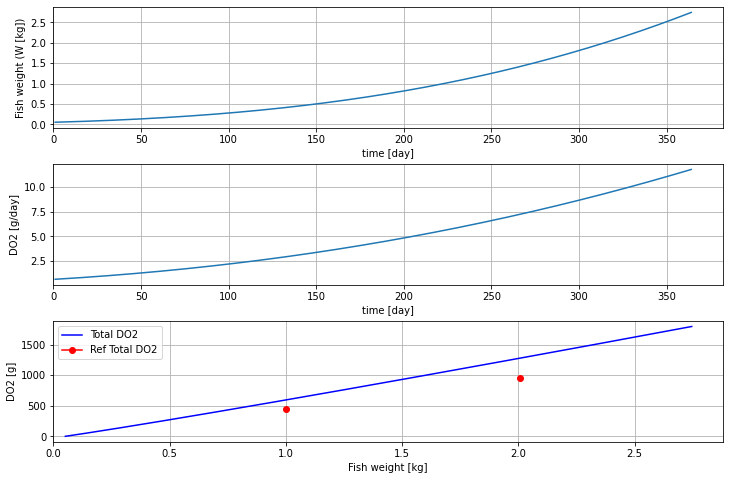

In [2]:
x_opt = res[best_idx].x
modules.plot_variable(x_opt, x_name, p)

# Plot objective function and constraints

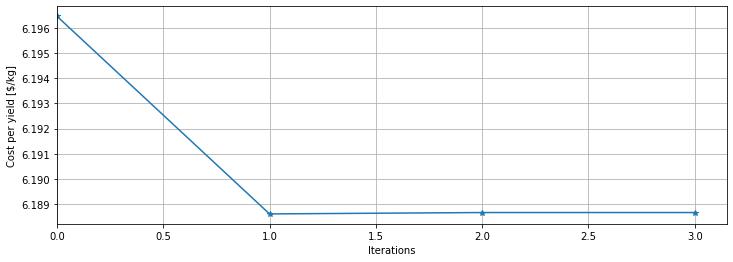

In [3]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
ax.plot(op_obj.f, marker='*')
ax.set(xlabel='Iterations', ylabel='Cost per yield [$/kg]')
#ax.legend()
ax.grid(True)
ax.set_xlim(0, None)
plt.show()

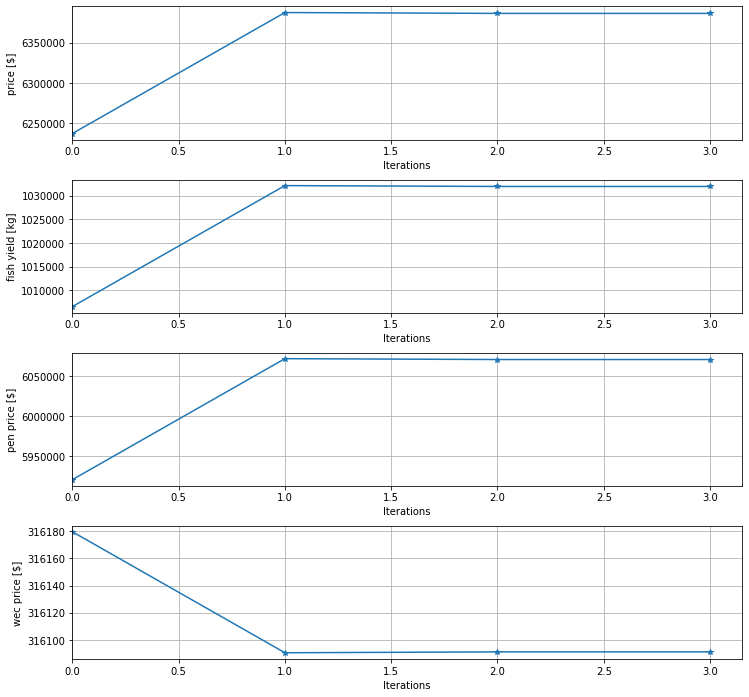

In [4]:
item_no = len(modules.obj_terms(x0, x_name, p)) - 1  # the first onw is objective func
item_name = ['price [$]', 'fish yield [kg]', 'pen price [$]', 'wec price [$]']
fig, ax = plt.subplots(item_no,1, figsize=(12, 12))

for i in range(item_no):
    ax[i] = plt.subplot(item_no,1,i+1)
    ax[i].plot(op_obj.obj_history[:, i+1], marker='*')
    ax[i].set(xlabel='Iterations', ylabel=item_name[i])
    #ax[i].legend(x_list)
    plt.grid(True)
    ax[i].set_xlim(0, None)
    ax[i].ticklabel_format(useOffset=False, style='plain', axis='y')
    #ax[i].yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))


plt.subplots_adjust(hspace=0.3)
plt.show()

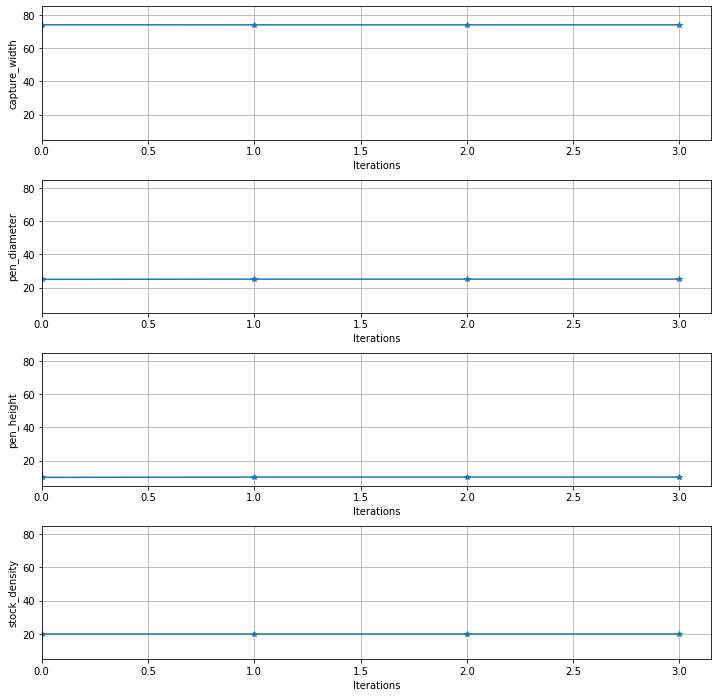

In [5]:
fig, ax = plt.subplots(len(x_list),1, figsize=(12, 12))

for i in range(len(x_list)):
    ax[i] = plt.subplot(len(x_list),1,i+1)
    ax[i].plot(op_obj.x_history[:, i], marker='*')
    ax[i].set(xlabel='Iterations', ylabel=x_list[i])
    #ax[i].legend(x_list)
    plt.grid(True)
    ax[i].set_xlim(0, None)
    ax[i].set_ylim(5, 85)
    #ax[i].ticklabel_format(useOffset=False, style='plain', axis='y')
    #ax[i].yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))


plt.subplots_adjust(hspace=0.3)
plt.show()

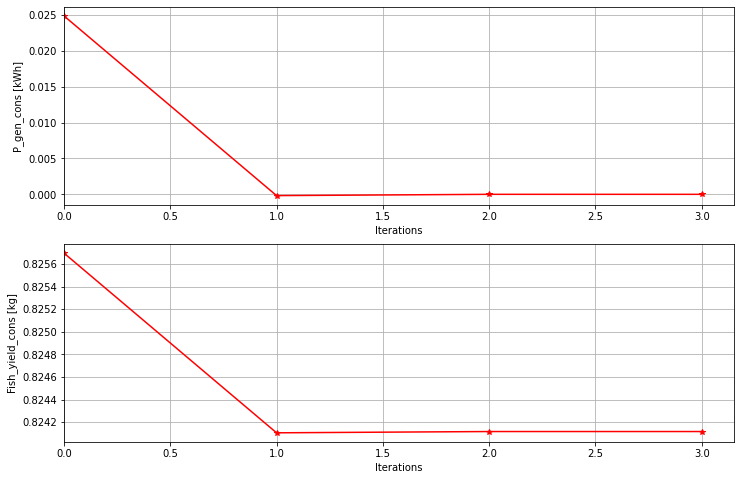

In [6]:
fig, ax = plt.subplots(2,1, figsize=(12, 8))

ax1 = plt.subplot(2,1,1)
ax1.plot(op_obj.ineq[:, 0], 'r', marker='*')
ax1.set(xlabel='Iterations', ylabel='P_gen_cons [kWh]');
#ax1.legend()
ax1.grid(True)
ax1.set_xlim(0, None)

ax2 = plt.subplot(2,1,2)
ax2.plot(op_obj.ineq[:, 1], 'r', marker='*')
ax2.set(xlabel='Iterations', ylabel='Fish_yield_cons [kg]');
#ax2.legend()
ax2.grid(True)
ax2.set_xlim(0, None)
plt.show()
